# Homework 3 Part 2 | Frank Yue Ying | yying2

### Packages needed: pandas, numpy, sklearn, matplotlib, shap

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk # import scikit-learn
from sklearn import preprocessing # import preprocessing utilites

In [2]:
df = pd.read_csv("death_causes.csv")
df.columns.values[0] = "id"

#### Question 1

In [3]:
# Referenced from Homework 1: Home_loan_Prediction
def feature_engineering(df):
    features_cat = ['sex', 'race','education','month_of_death','day_of_week_of_death','manner','relationship_status']
    features_num = ['age']
    X_cat = df[features_cat]
    X_num = df[features_num]
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_cat)
    one_hot = enc.transform(X_cat)
    X_cat_proc = pd.DataFrame(one_hot.toarray(), columns=enc.get_feature_names_out())
    scaled = preprocessing.scale(X_num)
    X_num_proc = pd.DataFrame(scaled, columns=features_num)
    df_result = pd.concat([X_num_proc, X_cat_proc], axis=1, sort=False)
    return df_result

In [4]:
# Model No.1 Predicting Cancer using Linear Regression
from sklearn.linear_model import LinearRegression
df_1 = df.drop(columns=['id', 'icd_code','cause'])
df_1["label"] = np.where(df_1["group"] == "Cancer", 1, 0)
df_1 = df_1.drop(columns=['group'])
X_1 = feature_engineering(df_1)
y_1 = df_1["label"]
model_1 = LinearRegression().fit(X_1, y_1)

In [5]:
# Model No.2 Predicting Drug Use using Logistic Regression
from sklearn.linear_model import LogisticRegression
df_2 = df.drop(columns=['id', 'icd_code','cause'])
df_2["label"] = np.where(df_2["group"] == "Drug Use", 1, 0)
df_2 = df_2.drop(columns=['group'])
X_2 = feature_engineering(df_2)
y_2 = df_2["label"]
model_2 = LogisticRegression(solver='lbfgs',max_iter=200).fit(X_2, y_2)

In [6]:
# Model No.3 Predicting MVA using Decision Tree
from sklearn.tree import DecisionTreeClassifier
df_3 = df.drop(columns=['id', 'icd_code','cause'])
df_3["label"] = np.where(df_3["group"] == "Motor Vehicle Accident", 1, 0)
df_3 = df_3.drop(columns=['group'])
X_3 = feature_engineering(df_3)
y_3 = df_3["label"]
model_3 = DecisionTreeClassifier(criterion = 'gini').fit(X_3, y_3)

#### Question 2

In [7]:
df_test = pd.DataFrame().reindex(columns=df.columns)

In [8]:
miles = {'id': 'Miles', 'age':20, 'sex':'M', 'race':'Black', 'education':6, 'month_of_death':12,
       'day_of_week_of_death':3, 'manner':'Natural Causes', 'relationship_status':'Single', 'icd_code':'',
       'cause':'', 'group':''}
jonas = {'id': 'Jonas', 'age':72, 'sex':'M', 'race':'White', 'education':3, 'month_of_death':8,
       'day_of_week_of_death':4, 'manner':'Natural Causes', 'relationship_status':'Widowed', 'icd_code':'',
       'cause':'', 'group':''}
alma = {'id': 'Alma', 'age':36, 'sex':'F', 'race':'Hispanic', 'education':6, 'month_of_death':3,
       'day_of_week_of_death':3, 'manner':'Natural Causes', 'relationship_status':'Single', 'icd_code':'',
       'cause':'', 'group':''}
df_test = pd.concat([df,pd.DataFrame([miles]),pd.DataFrame([jonas]),pd.DataFrame([alma])], ignore_index = True)
X_test = feature_engineering(df_test)

In [9]:
# Visualize Test data and features
df_test[df_test['id'].isin(["Miles","Jonas","Alma"])]

,id,age,sex,race,education,month_of_death,day_of_week_of_death,manner,relationship_status,icd_code,cause,group
100000,Miles,20,M,Black,6.0,12,3,Natural Causes,Single,,,
100001,Jonas,72,M,White,3.0,8,4,Natural Causes,Widowed,,,
100002,Alma,36,F,Hispanic,6.0,3,3,Natural Causes,Single,,,


In [10]:
test_index = df_test[df_test['id'].isin(["Miles","Jonas","Alma"])].index.tolist()
X_test = X_test.iloc[test_index]
X_test = X_test.drop(columns=['race_Hispanic'])

In [11]:
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)

### Model Predictions
| Header | Model 1 | Model 2 |Model 3 |
| --- | --- | --- | --- |
| Model Type |  Linear Regression | Logistic Regression | Decision Tree |
| Prediction |  Cancer | Drug Use | Motor Vehicle Accident |
| Miles | 0 | 0 | 0 |
| Jonas | 0 | 0 | 0 |
| Alma | 0 | 0 |0 |

###### Using SHAP to help explain the models 

In [12]:
import shap
shap.initjs()

In [13]:
explainer_1 = shap.Explainer(model_1.predict, X_1)
shap_values_1 = explainer_1(X_test)

##### Explaining Why Model 1 Predict Not Cancer for Miles
Seems like features such as month_of_death_12 and education_6 are influencing to predict Cancer whereas the other features are not.

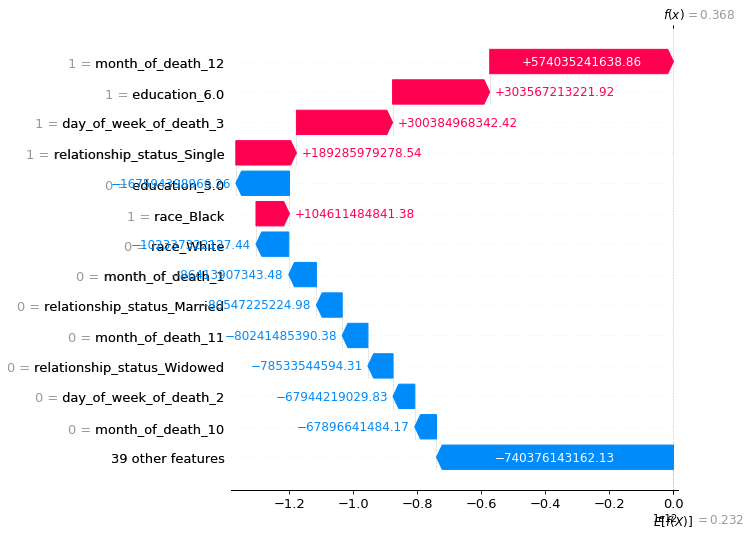

In [14]:
shap.plots.waterfall(shap_values_1[0], max_display=14)

##### Explaining Why Model 2 Predict Not Drug Use for Miles, Jonas, and Alma
Features such as manner_Accident, manner_Natural Causes, age, and race_white are the most important features with high magnitude effects.  

In [15]:
explainer_2 = shap.Explainer(model_2.predict, X_2)
shap_values_2 = explainer_2(X_test)

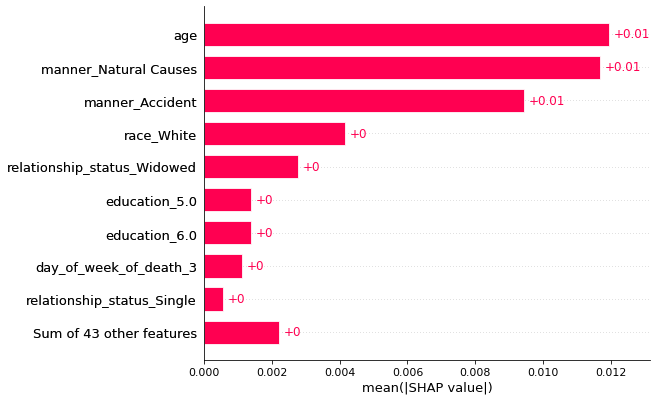

In [16]:
shap.plots.bar(shap_values_2)

##### Explaining Why Model 3 Predict Not Motor Vehicle Accident Use for Alma
Model started with age, sex and race to make the prediction. Unline previous models, day of the week and month num are not used in this one. 

In [17]:
# referenced from https://stackoverflow.com/questions/50553605/extract-rule-path-of-data-point-through-decision-tree-with-sklearn-python
n_nodes = model_3.tree_.node_count
dt_feature_names = list(X_3.columns)
children_left = model_3.tree_.children_left
children_right = model_3.tree_.children_right
feature = model_3.tree_.feature
threshold = model_3.tree_.threshold
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

node_indicator = model_3.decision_path(X_test)
leave_id = model_3.apply(X_test)
sample_id = 2
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:

    if leave_id[sample_id] == node_id:  # <-- changed != to ==
        #continue # <-- comment out
        print("leaf node {} reached, no decision here".format(leave_id[sample_id])) # <--

    else: # < -- added else to iterate through decision nodes
        print("decision id node %s, %s : Instance value - %s vs threshold - %s)"
              % (feature[node_id],
                 dt_feature_names[node_id],
                 X_test.iloc[sample_id][dt_feature_names[node_id]],
                 threshold[node_id]))

Rules used to predict sample 2: 
decision id node 45, age : Instance value - -2.2628213073208427 vs threshold - 0.5)
decision id node 32, sex_F : Instance value - 1.0 vs threshold - 0.5)
decision id node 0, sex_M : Instance value - 0.0 vs threshold - -2.4678508043289185)
decision id node 21, race_Korean : Instance value - 0.0 vs threshold - 0.5)
decision id node 30, relationship_status_Unkown : Instance value - 0.0 vs threshold - 0.5)
decision id node 26, relationship_status_Widowed : Instance value - 0.0 vs threshold - 0.5)
leaf node 52 reached, no decision here


In [18]:
from matplotlib import pyplot as plt

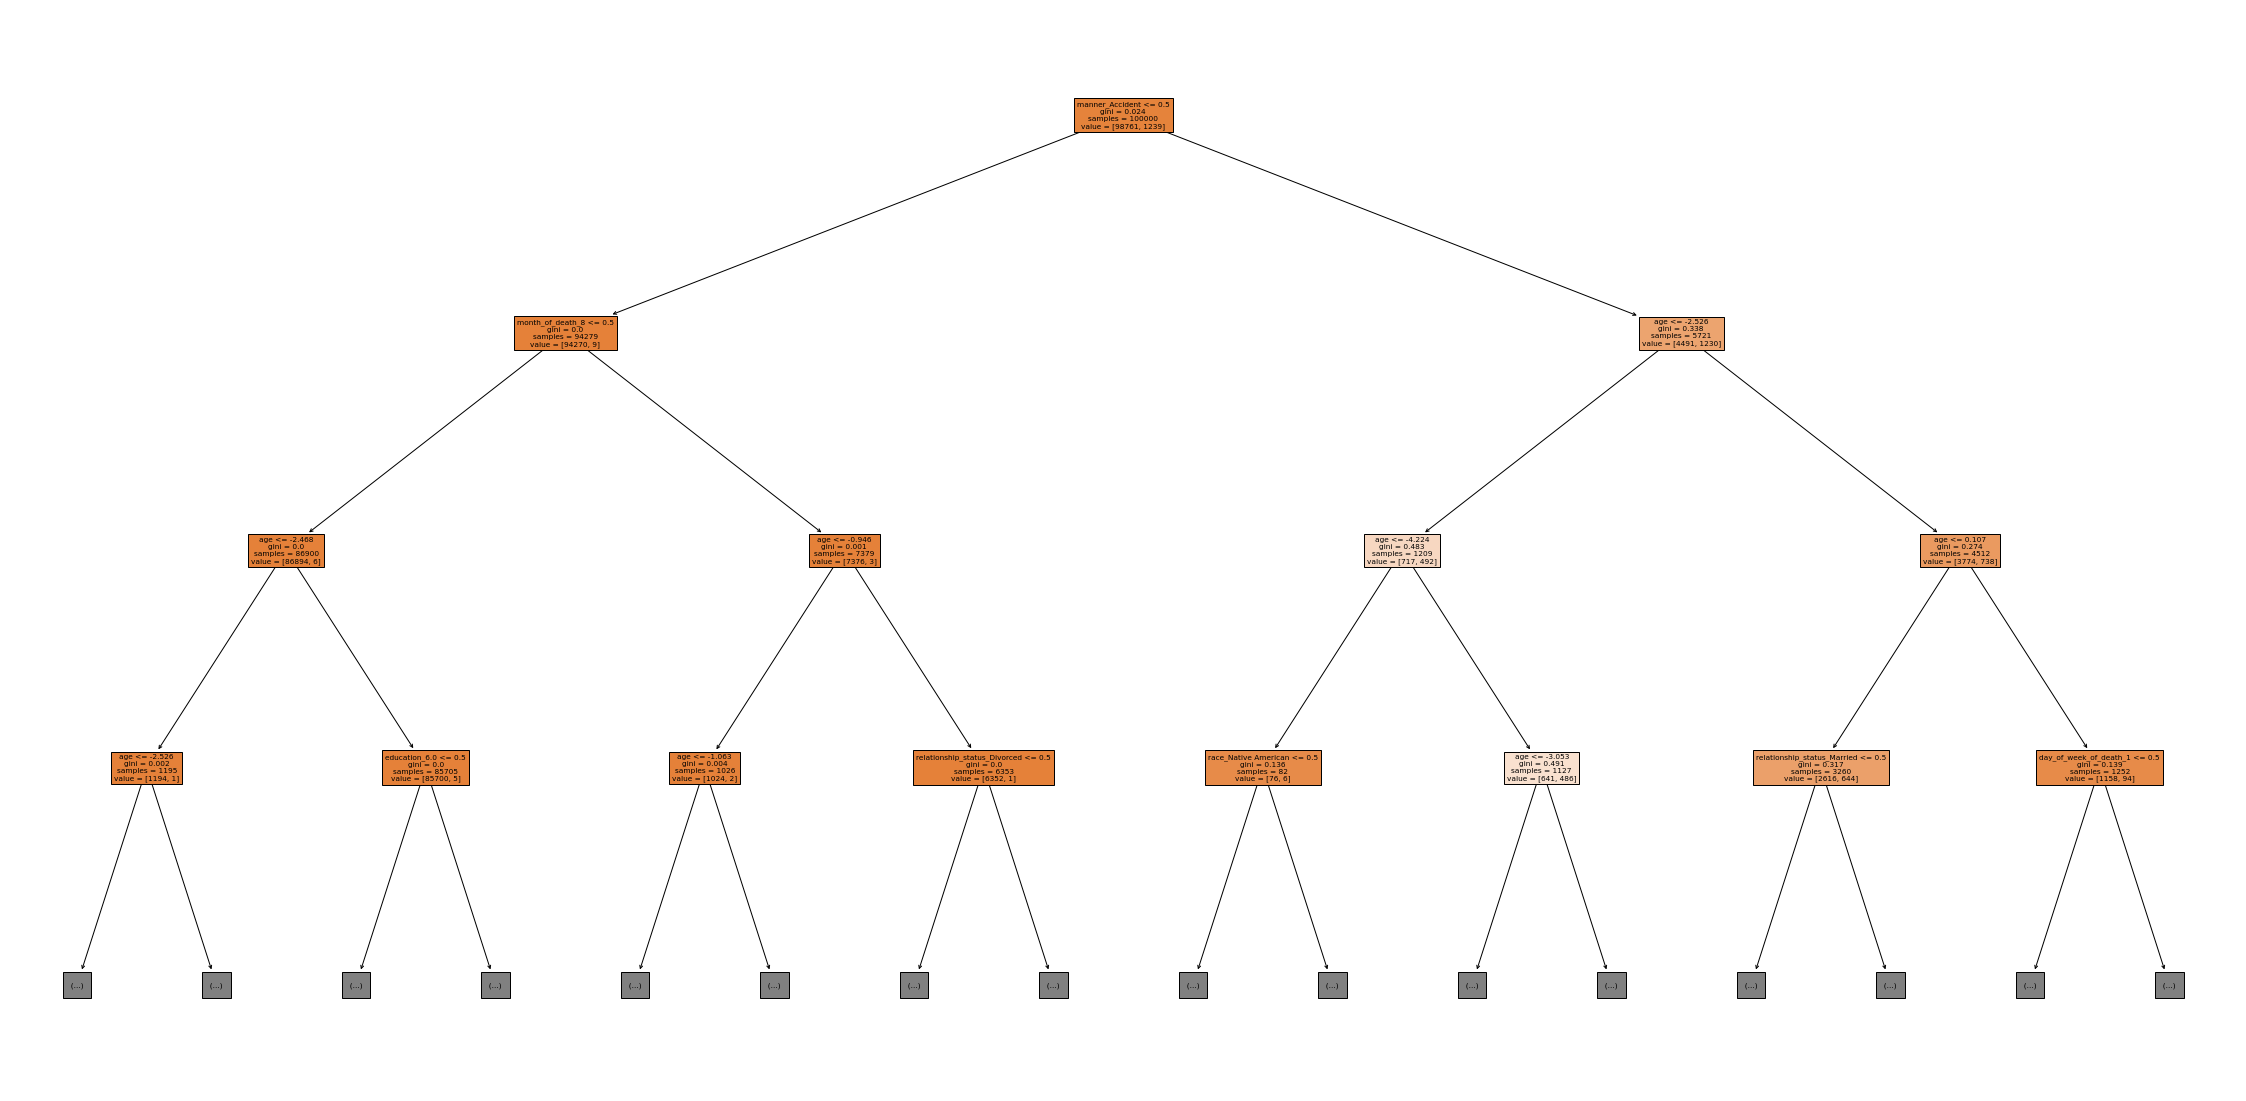

In [19]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = sk.tree.plot_tree(model_3,feature_names = X_test.columns,max_depth = 3,filled=True)
plt.show()